# Data Visualisation

In [1]:
import pandas as pd 
import glob 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
import os 
os.getcwd()

'/Users/julesbaudet/Documents/0. Cours/ENS/Deep Learning DIY/Projet final/DL_ens'

### Data Loading

In [3]:
path = "/Users/julesbaudet/Documents/0. Cours/ENS/Deep Learning DIY/Projet final/ens_data"
# path = "/Users/linusbleistein/Documents/Cours ENS/Cours mathématiques/Deep learning 2020-2021/data_project"

In [4]:
filelist = glob.glob(os.path.join(path, "brave/*.csv"))

In [5]:
li = []

for filename in filelist:
    df = pd.read_csv(filename)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [6]:
display(frame.head())
print(f'the data contains {frame.shape[0]} transactions')

,from_address,to_address,value,transaction_hash,log_index,block_hash,block_number,block_timestamp,unix_block_timestamp,forged
0,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,0xf142f26d1cac4ba8a6e6d7974d243eda2fe5f4f9,97.444845,0x01161737125d0308cd9b77949d29135ad7c4db332ec1...,69,0x302d44c68cf022ef74a1cc9eaba802fc859fbf10d789...,4252144,2017-09-08T15:47:18.000Z,1504885638,False
1,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x2733f4032b07ae40b00564cd7838c69d09e250a4,3428.070585,0x690227ce2c254e23bfd4e236117b7c0fb74961fbc5f9...,2,0x73f0cd4de834f9b5ca101405bf84a1581bbce08123e5...,4253534,2017-09-09T00:57:17.000Z,1504918637,False
2,0x73295d3c0ca46113ca226222c81c79adabf9f391,0x246a0810f2c18a68a979d07d28cda04fd95596de,169.778163,0x04a6b26a597dbbfa6513da07744c1cf3dd7021993722...,13,0x5e6a81215c16beefcbf0daa79034ad5dbc719ddc9a96...,4258823,2017-09-10T13:09:12.000Z,1505048952,False
3,0x1986607d10c7539e81e64c18c1b73ccf133cfd27,0x3e19c3544a05e5af9d81af9aec8ab39588aa3636,50.000000,0x5daa3810a61c326cbf2d2844b02e368ec005fa145a95...,20,0xf568503537a6fa70af2a75662b900791afd45bf3a63b...,4252266,2017-09-08T16:37:38.000Z,1504888658,False
4,0x73295d3c0ca46113ca226222c81c79adabf9f391,0xfab38571f4bffbf11f52ee9cbe309f018423f088,5087.291153,0x2d8017a2fb71767949809e99287a079d2db26877543d...,30,0xf91976261d03074011097685705debf1f97dac3ab14a...,4256714,2017-09-09T22:30:32.000Z,1504996232,False


the data contains 2695752 transactions


In [7]:
frame.groupby(by='forged').count()

,from_address,to_address,value,transaction_hash,log_index,block_hash,block_number,block_timestamp,unix_block_timestamp
forged,,,,,,,,,
False,2695566,2695566,2695566,2695566,2695566,2695566,2695566,2695566,2695566
True,186,186,186,186,186,186,186,186,186


## Data preparation

The data is composed of 269578 transactions, which have attributes: 
- from_address: address from which the transaction originated
- to_address: address to which the transaction was sent 
- value: amount of the transaction
- transaction_hash, log_index: couple of identifiants that uniquely identifies each transaction 
- block_hash: block identifier, a block is a list of transactions added at once to the blockchain 
- block_number: number of the block, the smaller the older
- block_timestamp: date at which the block was created
- unix_block_timestamp: date at which the block was created in unix time
- forged: True if the transaction was forged. There are 20 such transactions.

We start by: 
- removing forged transactions
- keeping only one unit of time, unix_block_timestamp

In [8]:
# is it the right thing to do? maybe keep them all, maybe delete all addresses involved in forged transactions 
frame = frame.loc[frame['forged']==False]
frame = frame.drop(columns = ['block_number','block_timestamp','forged'])

# we sort the transactions per date
frame = frame.sort_values('unix_block_timestamp')

We add two columns: _send_is_id_ (respectively _receive_is_id_ ) to indicate whether the sending (resp. receiving) address was identified as an exchange. 

In [9]:
# import the known exchange list 
exch_labels = pd.read_csv(os.path.join(path, "exchanges_encoded.csv"), 
                          delimiter=';', names  = ['address','label']).set_index('address')

labels = exch_labels.to_dict()['label'] # keys = addresses, values = name of the exchange
labels2int = dict(zip(labels.values(),[i for i in range(len(labels))])) # keys = addresses, values = name of the exchange
address2int = {k:labels2int[labels[k]] for k in labels.keys()}

known_addresses = list(labels.keys()) # list of all the addresses that were identified as exchanges

# add it to the dataframe
# frame['labels'] = [labels2int[labels[a]] if (a in labels.keys()) else np.nan for a in frame['from_address'].values]

In [10]:
frame['send_is_id'] = frame['from_address'].isin(known_addresses).astype(int)
frame['receive_is_id'] = frame['to_address'].isin(known_addresses).astype(int)

## Descriptive Statistics

In [11]:
#Counts the number of unique entries of 'from adress', i.e. the number of senders 
print(f'there are {frame["from_address"].nunique()} addresses sending transactions')

#Counts the number of unique entries of 'to adress', i.e. the number of receivers
print(f'there are {frame["to_address"].nunique()} addresses receiving transactions')

#Average value of transaction
print(f'the average value of a transaction is {frame["value"].mean()}')

addresses = pd.concat((frame["from_address"],frame["to_address"])).unique()
print(f'in total there are {addresses.shape[0]} addresses')

print(f'in total {len(known_addresses)} addresses were identified as exchanges (=plateforms).')

there are 717742 addresses sending transactions
there are 952784 addresses receiving transactions
the average value of a transaction is 16168.24980567251
in total there are 952894 addresses
in total 279 addresses were identified as exchanges (=plateforms).


There are more addresses _receiving_ cryptocurrency than _sending_.

In [12]:
frame['value'].describe()

count    2.695566e+06
mean     1.616825e+04
std      5.528669e+05
min      1.000000e-18
25%      5.316942e+01
50%      4.400000e+02
75%      3.197615e+03
max      3.663500e+08
Name: value, dtype: float64

In [13]:
exch = frame.loc[frame['send_is_id'] == 1]
non_exch = frame.loc[frame['send_is_id'] == 0]

print('senders identified as exchanges')
display(exch['value'].describe())
print('senders not identified as exchanges')
display(non_exch['value'].describe())

m = exch.groupby(by = 'from_address').count()['value'].mean()
print(f'in average, each exchange sent {round(m,3)} transactions')
m2 = non_exch.groupby(by = 'from_address').count()['value'].mean()
print(f'in average, each non exchange sent {round(m2,3)} transactions')

senders identified as exchanges


count    3.955430e+05
mean     1.990794e+04
std      4.213681e+05
min      5.120000e-15
25%      2.000000e+02
50%      1.460000e+03
75%      1.000596e+04
max      1.242279e+08
Name: value, dtype: float64

senders not identified as exchanges


count    2.300023e+06
mean     1.552512e+04
std      5.724428e+05
min      1.000000e-18
25%      4.180000e+01
50%      3.410462e+02
75%      2.477612e+03
max      3.663500e+08
Name: value, dtype: float64

in average, each exchange sent 4163.611 transactions
in average, each non exchange sent 3.205 transactions


In [14]:
exch = frame.loc[frame['receive_is_id'] == 1]
non_exch = frame.loc[frame['receive_is_id'] == 0]

print('receivers identified as exchanges')
display(exch['value'].describe())
print('receivers not identified as exchanges')
display(non_exch['value'].describe())

m = exch.groupby(by = 'to_address').count()['value'].mean()
print(f'in average, each exchange received {round(m,3)} transactions')
m2 = non_exch.groupby(by = 'to_address').count()['value'].mean()
print(f'in average, each non exchange received {round(m2,3)} transactions')

receivers identified as exchanges


count    2.385490e+05
mean     3.409209e+04
std      5.347883e+05
min      5.400000e-17
25%      6.515384e+02
50%      3.408225e+03
75%      1.660949e+04
max      1.242279e+08
Name: value, dtype: float64

receivers not identified as exchanges


count    2.457017e+06
mean     1.442804e+04
std      5.545600e+05
min      1.000000e-18
25%      4.721476e+01
50%      3.433131e+02
75%      2.489287e+03
max      3.663500e+08
Name: value, dtype: float64

in average, each exchange received 2409.586 transactions
in average, each non exchange received 2.579 transactions


In [15]:
exch = frame.loc[(frame['send_is_id'] == 1)|(frame['receive_is_id'] == 1)]
non_exch = frame.loc[(frame['send_is_id'] == 0)|(frame['receive_is_id'] == 0)]

In [16]:
a = exch[['from_address','unix_block_timestamp']].reset_index()
b = exch[['to_address','unix_block_timestamp']]
all_transactions_exch = pd.concat([a.rename(columns={'from_address': 'address'}), b.rename(columns={'to_address': 'address'})])
all_transactions_exch = all_transactions_exch.loc[all_transactions_exch['address'].isin(known_addresses)]

m = all_transactions_exch.groupby(by='address')['unix_block_timestamp'].nunique().mean()
print(f'on average, exchange addresses are active during {round(m,3)} blocks')

a = non_exch[['from_address','unix_block_timestamp']].reset_index()
b = non_exch[['to_address','unix_block_timestamp']]
all_transactions_nexch = pd.concat([a.rename(columns={'from_address': 'address'}), b.rename(columns={'to_address': 'address'})])
all_transactions_nexch = all_transactions_nexch.loc[~all_transactions_nexch['address'].isin(known_addresses)]

m = all_transactions_nexch.groupby(by='address')['unix_block_timestamp'].nunique().mean()
print(f'on average, exchange addresses are active during {round(m,3)} blocks')

on average, exchange addresses are active during 5400.869 blocks
on average, exchange addresses are active during 4.386 blocks


| | Exchange | Non-Exchange |
| --- | --- | --- |
|total # transactions sent | 39 435 | 230 123|
|total # transactions received | 23 798 | 245 760 |
|Avg Amount sent | 20 670.0 | 13 684.6 |
|Avg Amount received | 36 150.20 | 12 630.0 |
|Avg # active periods | 726.7 | 2.2 |
|Avg # transactions sent | 532.9 | 2.3 |
|Avg # transactions received | 293.8 | 1.8 |
|Avg # transactions in which involved | 826.7 | 4.1|


This table tends to indicate that addresses owned by exchanges are active much longer. 
Moreover, it seems that transactions involving exchanges are larger and that addresses owned by exchanges are involved in more transactions.

We now look at histograms for more granurality. 

In [17]:
def distrib_plot(frames, cat, sent = True, log = True):
    '''
    cat: string corresponding to a column of frame 
    
    plots the distribution of transactions per cat
    '''
    #Determine top senders 
    n = len(frames)
    f,ax=plt.subplots(1, n, figsize=(10*n,7))
    for i in range(n):
        if sent: 
            unique_senders = frames[i]["from_address"].unique()
            grouped_senders = frames[i].groupby(by="from_address").sum()
        
        else:
            unique_senders = frames[i]["to_address"].unique()
            grouped_senders = frames[i].groupby(by="to_address").sum()

        ax[i].hist(grouped_senders[cat], bins=200, weights=np.ones(grouped_senders.shape[0]) / grouped_senders.shape[0])
        ax[i].set_ylabel('# of transactions (log scale)')
        ax[i].set_xlabel(cat)
        #plt.xscale("log")
        status = 'sent' if sent else 'received'
        ax[i].set_title(f'Distribution of total amount of cryptocurrency {status} per {cat}')
        if log: 
            ax[i].set_yscale("log")

plot of the distribution of transaction value


/Users/julesbaudet/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:403: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


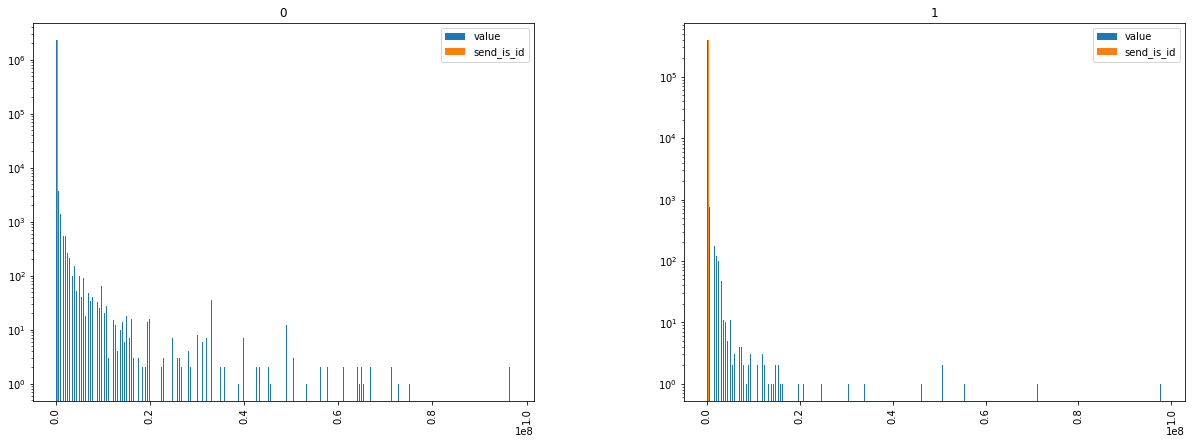

In [88]:
#distrib_plot(frame, 'value')
print('plot of the distribution of transaction value')
fig, ax = plt.subplots(1,2,figsize = (20,7))
frame[['value','send_is_id']].hist(by = 'send_is_id', bins = 200,log=True,ax=ax, sharex = True, sharey=True, legend = True)
plt.show()

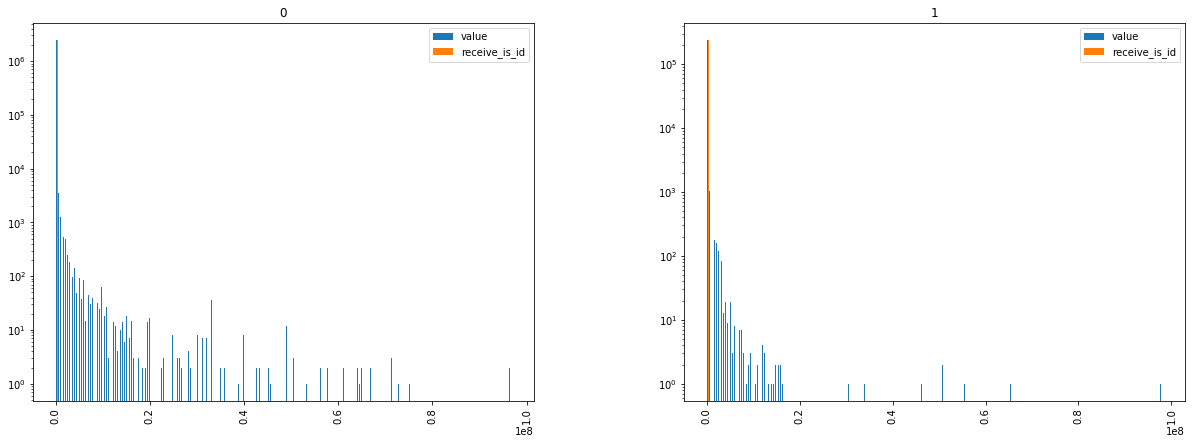

In [89]:
fig, ax = plt.subplots(1,2,figsize = (20,7))
frame[['value','receive_is_id']].hist(by = 'receive_is_id', bins = 200,log=True,ax=ax,legend=True)
plt.show()

Text(0.5, 1.0, 'distribution of transaction values')

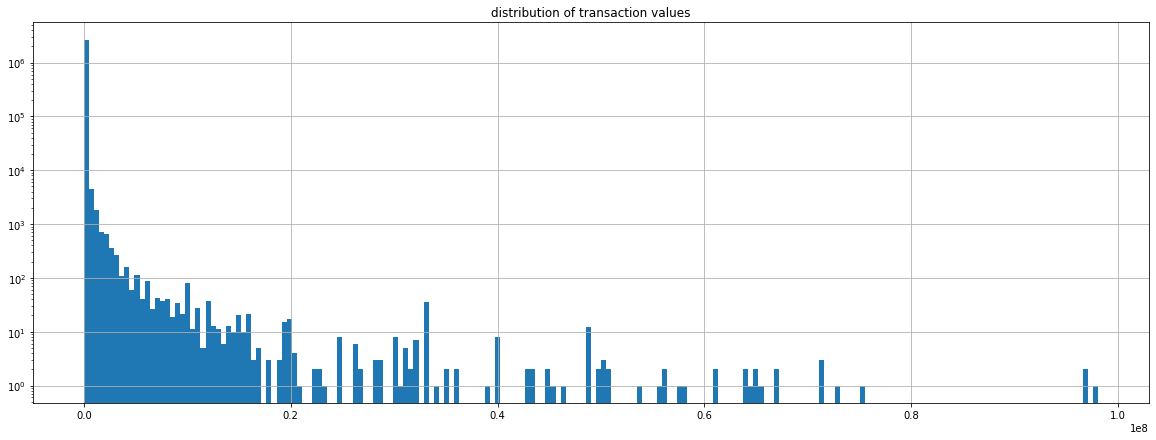

In [90]:
fig, ax = plt.subplots(figsize = (20,7))
frame['value'].hist(bins = 200)
ax.set_yscale('log')
plt.title('distribution of transaction values')

In [19]:
frame = frame.loc[frame['value'] <= 1e8]

left: exchange, right: non exchange


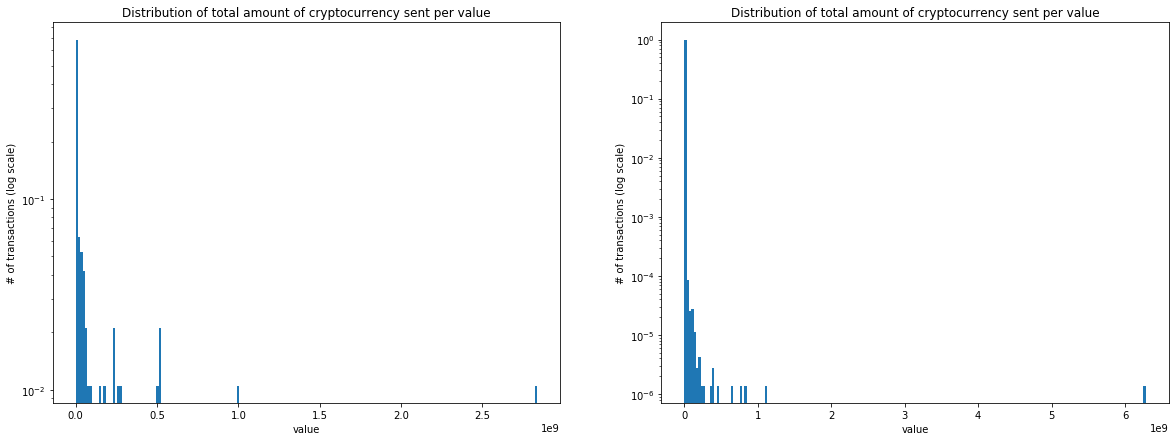

In [20]:
distrib_plot([frame.loc[frame['send_is_id']==1], frame.loc[frame['send_is_id']==0]],'value',sent = True)
print('left: exchange, right: non exchange')

left: exchange, right: non exchange


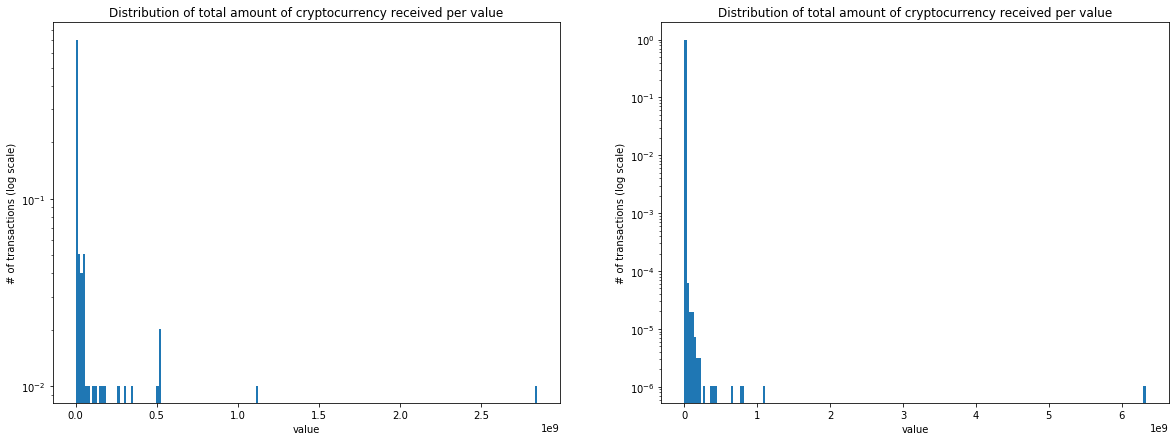

In [21]:
distrib_plot([frame.loc[frame['receive_is_id']==1], frame.loc[frame['receive_is_id']==0]],'value',sent = False)
print('left: exchange, right: non exchange')

first plot = exchanges, second = non exchanges


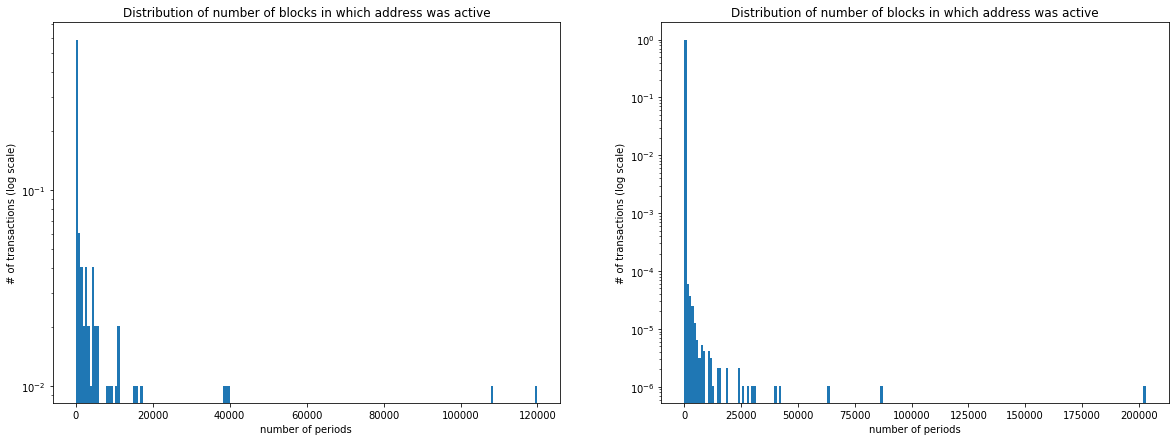

In [22]:
print('first plot = exchanges, second = non exchanges')
l = [all_transactions_exch.groupby(by='address').nunique(), all_transactions_nexch.groupby(by='address').nunique()]
f,ax=plt.subplots(1,2,figsize=(20,7))
for i in range(2):
    grouped_senders = l[i]
    ax[i].hist(grouped_senders['unix_block_timestamp'], bins=200,  weights=np.ones(grouped_senders.shape[0]) / grouped_senders.shape[0])
    ax[i].set_ylabel('# of transactions (log scale)')
    ax[i].set_xlabel('number of periods')
    ax[i].set_yscale("log")
    ax[i].set_title('Distribution of number of blocks in which address was active')
    # distrib_plot(frame.loc[frame['value'] <= 20000],'value')

In [23]:
#frame.sort_values('value',ascending=False)

,from_address,to_address,value,transaction_hash,log_index,block_hash,unix_block_timestamp,send_is_id,receive_is_id
1130774,0x4e9ce36e442e55ecd9025b9a6e0d88485d628a67,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,9.808516e+07,0x16203e20479fe02f55d92a88c06c0a8f37868c379752...,27,0x9f5355c1351474c0b1f74ef4751179172a91d29d53d9...,1562685849,1,1
646675,0x6c8c6b02e7b2be14d4fa6022dfd6d75921d90e4e,0x3ba21b6477f48273f41d241aa3722ffb9e07e247,9.674923e+07,0x1397b69482f751ae6646d1e0cce34448fafd05379f9a...,223,0x84bac05a267325f6d6b380b4322896d2370dde6f237f...,1593717445,0,0
1267123,0x3ba21b6477f48273f41d241aa3722ffb9e07e247,0x6c8c6b02e7b2be14d4fa6022dfd6d75921d90e4e,9.674923e+07,0x024a07f811a2e88b15039db3db9b65056400a213d7e7...,88,0x92b0c3004d0da70eaa829eb1cb6acec6b27c555e372b...,1593717522,0,0
376915,0x6c8c6b02e7b2be14d4fa6022dfd6d75921d90e4e,0x3ba21b6477f48273f41d241aa3722ffb9e07e247,7.503824e+07,0x6dd20d2baa6b481bf9931ef0a05f247b5bb6504d9f28...,87,0x41ef3369cfcfec5df2055c520db1397c7234590a56cd...,1593717572,0,0
1076588,0x3ba21b6477f48273f41d241aa3722ffb9e07e247,0x6c8c6b02e7b2be14d4fa6022dfd6d75921d90e4e,7.273146e+07,0x62330817b74b3a7279c77715290d1fa47213e9c4c108...,114,0x95994913dbae25dcc766cd508471d8133039f70a49e5...,1593717606,0,0
...,...,...,...,...,...,...,...,...,...
2160748,0xfb15e5be48ca83ea95bbb8ffda468ffb75a1ad0e,0x89d3a6b4568836b51fcdf7c6d5c150d88da1561f,1.000000e-18,0xadf8be0b928a954612a8e60bfa973ef1adc03bae3f70...,60,0xe9a822230968e9d491c0492de78d9d88ae556ebef5e3...,1508143986,0,0
1496428,0x410f56d1d947361e20fe7950cd73c4d3fd198d21,0x450bfa3b245ccce640843df5e37e47c8edfd6adb,1.000000e-18,0x71a500656b60df511577ba23e9bf0f3775114f6fe2dd...,5,0xb7fd4e0b8b5b2f7702ae7add441f3f1f29af2fdff5fa...,1509029372,0,0
1623126,0xdc4090e4f2cb10664ee44df9814107fffb051c35,0x1cf5623db4a34f944e05f99fd229908affeebd06,1.000000e-18,0x539f039186bb3decead95bef299207a7d6bd3342fce6...,8,0x1dfcbf74a7e472b0b47c8862b0c29812ff895497ac96...,1509588067,0,0
749949,0x3c82ae6bef5db2c08b038d2dbd513ad29e77c7d5,0x14108647179ea5661814d547e9dd8a23af6aa7b0,1.000000e-18,0xa10ed746b8fa1e9cb8a4b2cce1fef45d2432896901e4...,31,0x4ecb22261c2499246cb32f73b629f817ec49ac276e25...,1508273398,0,0


In [64]:
f2 = frame.groupby(by = 'from_address').sum()#['value']

In [65]:
f2

,value,log_index,unix_block_timestamp,send_is_id,receive_is_id
from_address,,,,,
0x000000000000006f6502b7f2bbac8c30a3f67e9a,9.995243e+06,76978,1028966197130,0,0
0x0000000000000d9054f605ca65a2647c2b521422,1.119780e+05,546,6398075373,0,0
0x0000000000000eb4ec62758aae93400b3e5f7f18,1.312074e+04,2319,19270487007,0,0
0x00000000000017c75025d397b91d284bbe8fc7f2,1.353464e+05,778,9632749397,0,0
0x00000000000043dc09b2d31827cb23f414e1fa3d,1.552187e+05,1326,25564816514,0,0
...,...,...,...,...,...
0xffffd40c8ce69fc10ddb2f3e424dc28ae0fd33e8,1.980592e+02,206,1604281330,0,0
0xffffd78093141d7e2eb923b76053effcec377fbf,5.000000e+01,210,1579192816,0,0
0xffffe661474073010cb7ab1f8af7b4505af6df5c,2.000000e+02,56,1554112221,0,0


In [73]:
f2.loc[f2['value'] > 1e8]

,value,log_index,unix_block_timestamp,send_is_id,receive_is_id
from_address,,,,,
0x030e37ddd7df1b43db172b23916d523f1599c6cb,1.565360e+08,532,49694544719,0,32
0x0681d8db095565fe8a346fa0277bffde9c0edbbf,5.069727e+08,1100927,64258748099688,41036,901
0x07320deb2713370a3d7b49189fc2f99906e1ae8e,1.476852e+08,40896,1361141025654,0,0
0x0eb4add4ba497357546da7f5d12d39587ca24606,2.033658e+08,2324,30284833217,0,0
0x1671a3e4a2519a653e66e827ef6eae690ee86729,1.429030e+08,77992,2368436431441,0,1505
0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,1.226905e+08,42425,1583449472910,0,0
0x29728d0efd284d85187362faa2d4d76c2cfc2612,1.312339e+08,634681,13754571516266,0,0
0x330b5c25a27ad933f4a760d4b88c14382579ee17,1.062250e+08,1718,42462673996,0,0
0x340d693ed55d7ba167d184ea76ea2fd092a35bdc,2.058851e+08,28980078,502258845329939,0,0


In [25]:
def graph_plot(frame, t_min, t_max, plot_type = 'circular', savefig=False):
    '''
    function that plots the graph (V=addresses, E=transactions) for transactions between t_min and t_max
    '''
    gframe = frame.loc[(frame['unix_block_timestamp'] >= t_min) & (frame['unix_block_timestamp'] <= t_max)]
    
    # create edges weighted by amount of transaction (i.e. 'value' in df)
    edgelist = [(a,b,w) for a,b,w in zip(gframe.from_address, gframe.to_address, frame.value)]
    G = nx.DiGraph()
    G.add_weighted_edges_from(edgelist) # edgeliste[:100]
    
    # assign each node value -1 if not identified, else integer exchange identifier
    val = {i:address2int[i] if (i in address2int.keys()) else -1 for i in G.nodes}
    nx.set_node_attributes(G, val,'val')
    
    f,ax=plt.subplots(figsize=(20,20))
    
    if plot_type == 'circular':
        nx.draw_circular(G, node_color = list(nx.get_node_attributes(G,'val').values()), cmap = plt.cm.get_cmap('rainbow'),
                         alpha = 0.4, node_size=[v * 100 for v in dict(G.degree).values()])#, pos)
    elif plot_type == 'random':
        nx.draw_random(G, node_color = list(nx.get_node_attributes(G,'val').values()), cmap = plt.cm.get_cmap('rainbow'),
                         alpha = 0.4, node_size=[v * 100 for v in dict(G.degree).values()])#, pos)
    elif plot_type == 'spring':
        nx.draw_spring(G, node_color = list(nx.get_node_attributes(G,'val').values()), cmap = plt.cm.get_cmap('rainbow'),
                         alpha = 0.4, node_size=[v * 100 for v in dict(G.degree).values()])#, pos)
    
    if savefig:
        plt.savefig(f"graph_{np.datetime64('now').astype('str')}.pdf")

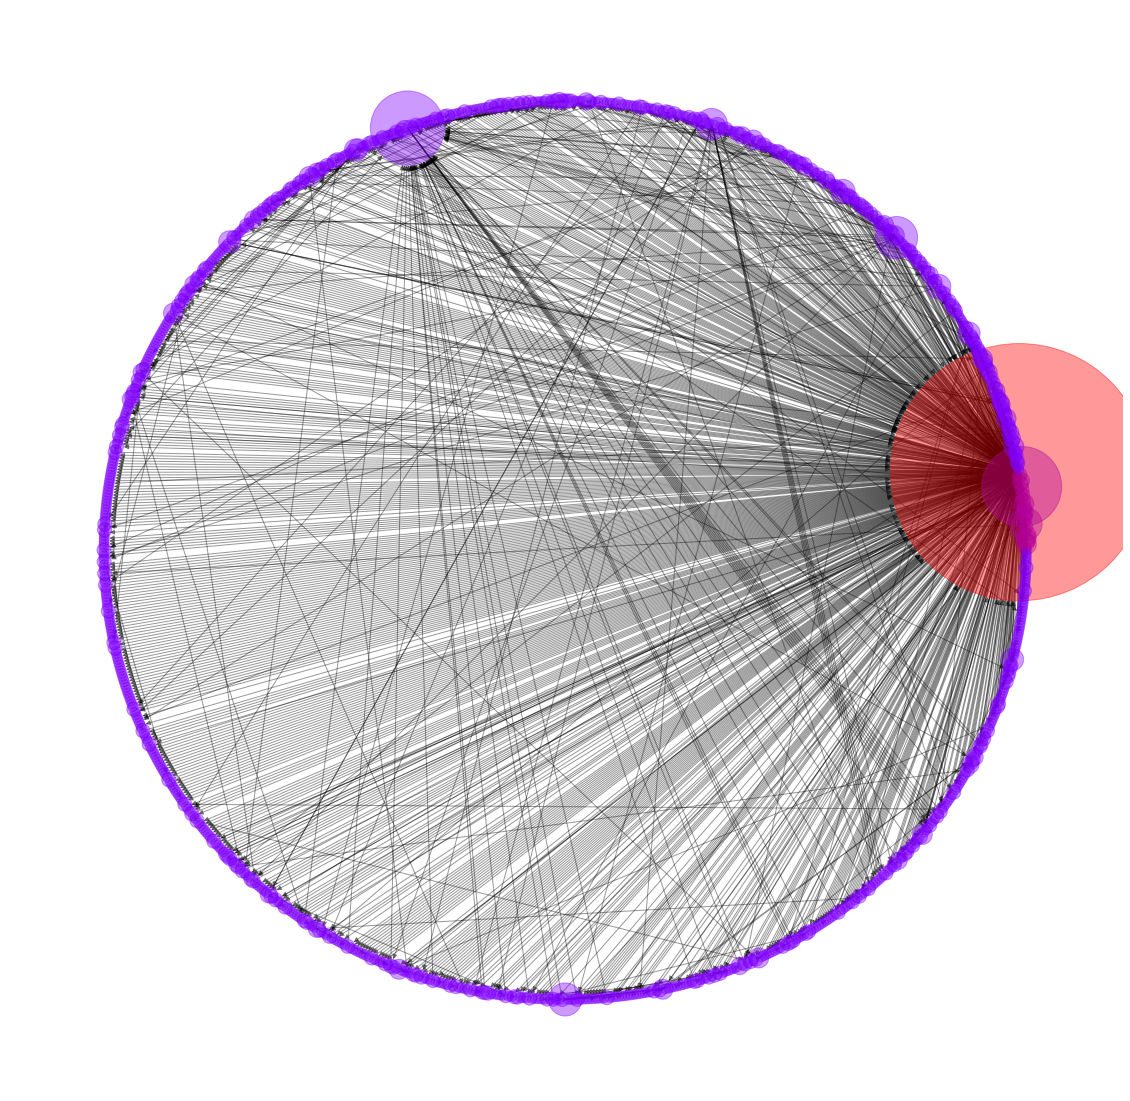

In [26]:
graph_plot(frame, frame.iloc[0]['unix_block_timestamp'],frame.iloc[2000]['unix_block_timestamp'], 'circular')

In [27]:
# create frame with only transactions involving identified exchanges 
frame_id = frame.loc[(frame['from_address'].isin(known_addresses)) | (frame['to_address'].isin(known_addresses))]

print(f'there are {frame_id.size} transactions involving an identified exchange, that is {(100*frame_id.size/frame.size).round(2)}% of all transactions')

there are 5603373 transactions involving an identified exchange, that is 23.1% of all transactions


In [28]:
#test  = frame.loc[frame['from_address'].isin(['0x008932be50098089c6a075d35f4b5182ee549f8a', '0x0093e5f2a850268c0ca3093c7ea53731296487eb', 
#                                      '0x03bdf69b1322d623836afbd27679a1c0afa067e9', '0x05f51aab068caa6ab7eeb672f88c180f67f17ec7',
#                                      '0xfe9e8709d3215310075d67e3ed32a380ccf451c8','0x0c6c34cdd915845376fb5407e0895196c9dd4eec']) ]

In [29]:
# graph_plot(test, test.iloc[0]['unix_block_timestamp'],test.iloc[-1]['unix_block_timestamp'])

In [30]:
# gtest = frame.groupby(by="from_address").count()
# gtest.loc[(gtest.index.isin(known_addresses))].iloc[:30]

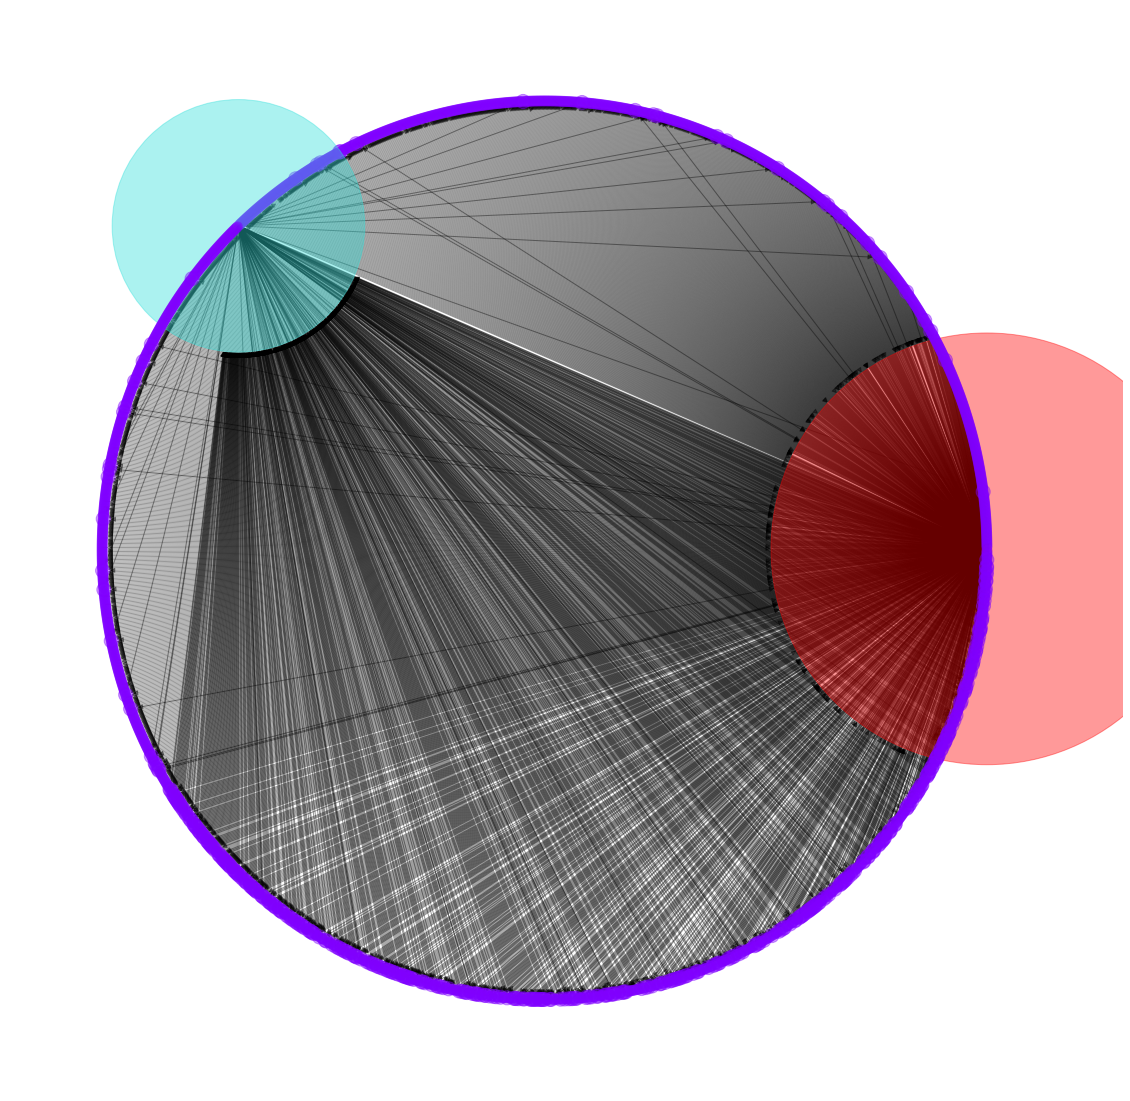

In [31]:
graph_plot(frame_id, frame_id.iloc[0]['unix_block_timestamp'],frame_id.iloc[5000]['unix_block_timestamp'])

TypeError: 'numpy.ndarray' object is not callable

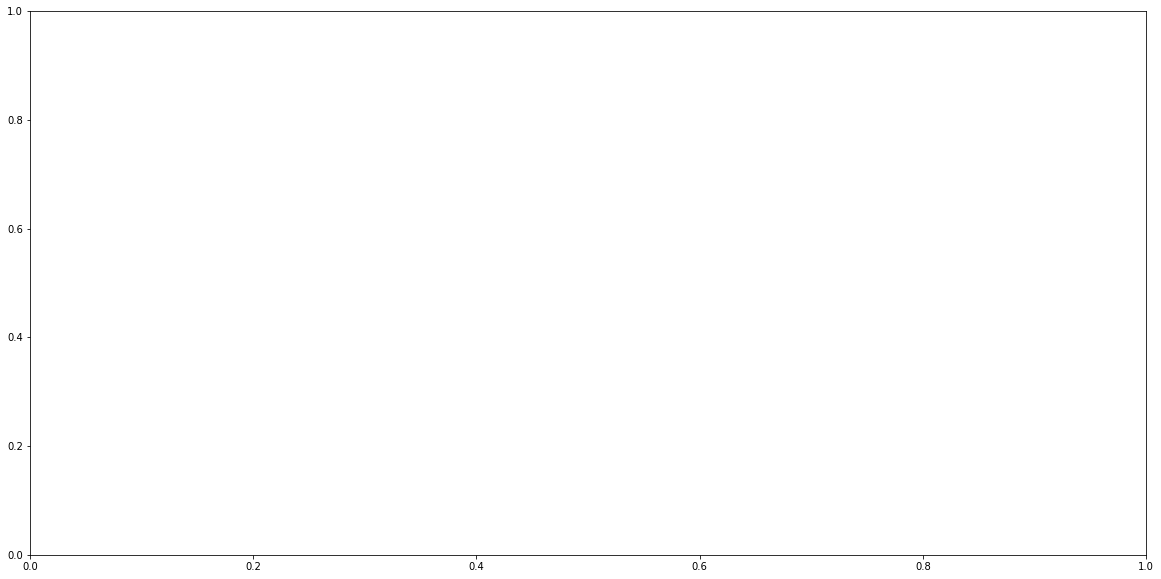

In [32]:
exch = frame.loc[frame['send_is_id'] == 1]
non_exch = frame.loc[frame['send_is_id'] == 0]

fig, ax = plt.subplots(figsize = (20,10))
ax.stackplot(exch.groupby(by='unix_block_timestamp').count()['from_address'].values(), non_exch.groupby(by='unix_block_timestamp').count()['from_address'].values())#  label = 'exchanges', label = 'non exchanges', linestyle='--', alpha=0.4)
plt.title('Number of transactions sent as a function of time')
plt.legend()








exch = frame.loc[frame['receive_is_id'] == 1]
non_exch = frame.loc[frame['receive_is_id'] == 0]

fig = plt.figure(figsize = (20,10))
plt.plot(exch.groupby(by='unix_block_timestamp').count()['to_address'], label = 'exchanges')
plt.plot(non_exch.groupby(by='unix_block_timestamp').count()['to_address'], label = 'non exchanges', linestyle='--', alpha=0.4)
plt.title('Number of transactions received as a function of time')
plt.legend()

plt.show()

In [ ]:
#Histogram for the number of transactions (sent) per wallet

#count_frame = frame.groupby(by="from_address").count()
#f,ax=plt.subplots(figsize=(10,10))
#plt.hist(count_frame.to_address,bins=40)
#plt.yscale("log")
#plt.ylabel("# of wallets")
#plt.xlabel("# of transactions")

In [ ]:
frame_copy = frame
frame_copy["block_timestamp"] = frame_copy["block_timestamp"].str[:10]
frame_copy=frame_copy.groupby(by="block_timestamp").count()



f,ax=plt.subplots(figsize=(20,10))
plt.plot(frame_copy.from_address)
plt.plot(eth_data_correct_time.high)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
#plt.yscale("log")
plt.ylabel("# of transactions (log scale)")
plt.xlabel("Time")
plt.savefig("ntransac.pdf")


In [ ]:
# frame["block_timestamp"][0:10]
#edgeliste = [(a,b) for a,b in zip(frame.from_address, frame.to_address)]
#G = nx.from_edgelist(edgeliste[:500], create_using=nx.DiGraph) # edgeliste[:100]
#f,ax=plt.subplots(figsize=(20,20))
#nx.draw_spring(G)
#edgeliste = [(a,b,w) for a,b,w in zip(frame.from_address, frame.to_address, frame.value)]
#G_w = nx.DiGraph()
#G_w.add_weighted_edges_from(edgeliste[:500]) # edgeliste[:100]
#f,ax=plt.subplots(figsize=(20,20))
#nx.draw_spring(G)# frame["block_timestamp"][0:10]

In [ ]:
# gframe = frame.iloc[:70]
# edgelist = [(a,b,w) for a,b,w in zip(gframe.from_address, gframe.to_address, frame.value)]
# G = nx.DiGraph()
# G.add_weighted_edges_from(edgelist) # edgeliste[:100]
# 
# val = {i:address2label[i] if (i in address2label.keys()) else -1 for i in G.nodes}
# nx.set_node_attributes(G, val,'val')
# 
# f,ax=plt.subplots(figsize=(20,20))
# nx.draw_spring(G, node_color = list(nx.get_node_attributes(G,'val').values()), cmap = plt.cm.get_cmap('rainbow'))#, pos)

In [ ]:
# frame['block_timestamp'] = pd.to_datetime(frame['block_timestamp'])
# frame = frame.sort_values('block_timestamp')

#frame['block_timestamp'] = pd.to_numeric(frame['block_timestamp'])
#frame['block_timestamp'] = frame['block_timestamp'] - frame['block_timestamp'].min()

## Data preprocessing

In [ ]:
frame.head()

test_address = '0x88e2efac3d2ef957fcd82ec201a506871ad06204'

received = frame.groupby(['to_address']).sum()['value'] #Somme totale reçue par les adresses 
given = frame.groupby(['from_address']).sum()['value'] #Sommes envoyées par les adresses 
received = received.to_frame()
given = given.to_frame()

In [ ]:
received.max()

In [ ]:
received = received.rename(columns={"value": "received_value"})
given = given.rename(columns={"value": "given_value"})


result = pd.concat([received,given],join='outer')
result=result.fillna(0)
result = result.groupby(result.index).sum()
result['net_value'] = result['received_value']-result['given_value']


In [ ]:
result[80:100]
result.net_value.describe()

In [ ]:
small_frame = frame.sample(1000)
small_frame.head()

In [ ]:
#ne fonctionne pas encore

def feature_extraction(df):
    
    feature_tensor = torch.zeros()
    edgelist = [(a,b) for a,b in zip(df.from_address, df.to_address)]
    G = nx.Graph()
    G.add_edges_from(edgelist)
    adjacency_matrix = matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
    sum_frame = df.groupby('from_address').sum()
    


    

In [ ]:
#Goal: convert this small_frame into a list of nodes + adjacence matrix + features 

edgelist = [(a,b) for a,b in zip(small_frame.from_address, small_frame.to_address)]
G = nx.Graph()
G.add_edges_from(edgelist)
matrix = nx.linalg.graphmatrix.adjacency_matrix(G)

In [ ]:
print(matrix.todense())

In [ ]:
value = small_frame.groupby('from_address').sum()
print(value.head())

In [ ]:
sys.exit

edgelist = [(a,b,w) for a,b,w in zip(small_frame.from_address, small_frame.to_address, small_frame.value)]
G = nx.DiGraph()
G.add_weighted_edges_from(edgelist)
print(list(G.adj['0xed894e062dbdf3a3690e59a1c855507ba8468e31']))